# Import statements

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import random
import os
import sys

# import keras
import keras
from keras import backend as K
backend_keras = keras.backend.backend()
print("keras is using", backend_keras, "as the backend")
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model, load_model, Sequential

# for training
# https://keras.io/optimizers/ - list of optimizers, keras documentation
from keras.optimizers import SGD, Nadam, Adamax, Adam, Adadelta, Adagrad, RMSprop


keras is using tensorflow as the backend


# Load preprocessed data
These are the ones which have been created with the keras notebook

In [36]:
os.listdir()

['preprocessing.ipynb',
 'CNN1_fixed_redshift_esc_frac_train_no_encoder.ipynb',
 'redshift0750_data.npy',
 'redshift0750_labels_test.npy',
 'keras_architecture_01_with_encoder.model',
 'keras_architecture_04_with_encoder.model',
 'architecture_03.png',
 'training_performance_250_architecture_04_autoencoder.png',
 'training_performance_100_architecture_02_autoencoder.png',
 'redshift0750_data_train.npy',
 'Screenshot at 2019-11-18 02-31-25.png',
 'architecutre_01.png',
 'training_performance_100_architecture_01_autoencoder.png',
 'training_performance_100_architecture_03_autoencoder.png',
 '.ipynb_checkpoints',
 'architecture_02.png',
 'redshift0750_labels_train.npy',
 'redshift0750_labels.npy',
 'redshift0750_data_test.npy',
 'CNN1_fixed_redshift_esc_frac_train_with_autoencoder.ipynb',
 'training_performance_no_encoder_150_architecture_01.png']

In [37]:
x_train_raw = np.load("redshift0750_data_train.npy")
x_test_raw = np.load("redshift0750_data_test.npy")
y_train_val = np.load("redshift0750_labels_train.npy")
y_test = np.load("redshift0750_labels_test.npy")

print(x_train_raw.shape)
print(x_test_raw.shape)
print(y_train_val.shape)
print(y_test.shape)

(2160, 200, 200, 1)
(240, 200, 200, 1)
(2160, 12)
(240, 12)


# Apply Autoencoder
## first load the autoencoder, and extract the encoder

In [38]:
os.listdir("../../Auto-Encoder Training/")
autoencoder = load_model("../../Auto-Encoder Training/autoencoder_adam_95.model")


In [39]:
#autoencoder.summary()

In [40]:
encoder = Model(autoencoder.input, autoencoder.layers[-8].output)

encoder.summary()

# this stackoverflow was useful
# https://stackoverflow.com/questions/52271644/extract-encoder-and-decoder-from-trained-autoencoder

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 8)       1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 8)         0   

In [41]:
x_train_val = encoder.predict(x_train_raw)

### train val split

In [42]:
ratio = 0.85
cut = int(len(x_train_val)*ratio)
x_train = x_train_val[:cut]
x_val = x_train_val[cut:]
y_train = y_train_val[:cut]
y_val = y_train_val[cut:]

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(1836, 25, 25, 8)
(324, 25, 25, 8)
(1836, 12)
(324, 12)


# Define the CNN architecture

Remember this one is a 12 class problem
Resourses used:
- Guid for implementing keras CNN https://towardsdatascience.com/image-recognition-with-keras-convolutional-neural-networks-e2af10a10114
- Guid to Sequential Model : https://keras.io/getting-started/sequential-model-guide/
- how padding works https://stackoverflow.com/questions/45013060/how-to-do-zero-padding-in-keras-conv-layer#45013181

Note : at the bottom of this cell the activation was 'sigmoid', I changed it to 'softmax' in the hope that this would allow me to plot the accuracy of the classifier. Also I think with softmax it will give me a definite answer...

In [43]:
classifier = Sequential()

# padding = 'valid' means that i reduce dimentionality a little

# extract features
classifier.add(Conv2D(16, (3,3), input_shape=(25,25,8),
                      activation='relu', padding='valid'))
# reduce dimensionality, keep most important info
classifier.add(MaxPooling2D(pool_size=(2,2)))

# add a second layer, again with no padding
classifier.add(Conv2D(8, (3,3), activation='relu', padding='valid'))

# pool again
classifier.add(MaxPooling2D(pool_size=(2,2)))

# Here I flatten and then guess the class
classifier.add(Flatten())

# fully connected layers: ensures connections to all activations in prev layer

classifier.add(Dense(units=12, activation='softmax'))

# Alternative Architecutres

In [17]:
classifier = Sequential()

# padding = 'valid' means that i reduce dimentionality a little

# extract features
classifier.add(Conv2D(16, (3,3), input_shape=(25,25,8),
                      activation='relu', padding='valid'))

classifier.add(Conv2D(16, (3,3), activation='relu', padding='valid'))
classifier.add(Conv2D(8, (3,3), activation='relu', padding='valid'))
classifier.add(Conv2D(8, (3,3), activation='relu', padding='valid'))

classifier.add(Flatten())

# fully connected layers: ensures connections to all activations in prev layer
classifier.add(Dense(units=256, activation='relu'))
classifier.add(Dense(units=12, activation='softmax'))

# Choose optimizer and compile netowrk
sparse_categorical

In [44]:
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
classifier.compile(optimizer=opt, 
                   loss='categorical_crossentropy',
                   metrics=["accuracy"])
print("printing summary of model")
classifier.summary()

printing summary of model
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 23, 23, 16)        1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 9, 9, 8)           1160      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 12)                1548      
Total params: 3,876
Trainable params: 3,876
Non-trainable params: 0
__________________________

# Train the network

In [47]:
print(x_train.shape)
print(x_val.shape,y_val.shape)

(1836, 25, 25, 8)
(324, 25, 25, 8) (324, 12)


In [29]:
EPOCHS = 150

H = classifier.fit(x_train, y_train,
                  epochs=EPOCHS,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(x_val, y_val))

Train on 1836 samples, validate on 324 samples
Epoch 1/150
1836/1836 [==============================] - 0s 215us/step - loss: 1.7560 - accuracy: 0.3175 - val_loss: 1.7378 - val_accuracy: 0.3426
Epoch 2/150
1836/1836 [==============================] - 0s 205us/step - loss: 1.7049 - accuracy: 0.3377 - val_loss: 1.6778 - val_accuracy: 0.3488
Epoch 3/150
1836/1836 [==============================] - 0s 214us/step - loss: 1.6579 - accuracy: 0.3513 - val_loss: 1.6409 - val_accuracy: 0.3549
Epoch 4/150
1836/1836 [==============================] - 0s 210us/step - loss: 1.6237 - accuracy: 0.3589 - val_loss: 1.6327 - val_accuracy: 0.3457
Epoch 5/150
1836/1836 [==============================] - 0s 230us/step - loss: 1.5938 - accuracy: 0.3736 - val_loss: 1.6025 - val_accuracy: 0.3426
Epoch 6/150
1836/1836 [==============================] - 1s 292us/step - loss: 1.5764 - accuracy: 0.3796 - val_loss: 1.5680 - val_accuracy: 0.3457
Epoch 7/150
1836/1836 [==============================] - 1s 363us/step 

1836/1836 [==============================] - 1s 302us/step - loss: 1.0978 - accuracy: 0.5468 - val_loss: 1.1569 - val_accuracy: 0.4907
Epoch 57/150
1836/1836 [==============================] - 1s 295us/step - loss: 1.0859 - accuracy: 0.5496 - val_loss: 1.1703 - val_accuracy: 0.4660
Epoch 58/150
1836/1836 [==============================] - 1s 305us/step - loss: 1.0899 - accuracy: 0.5517 - val_loss: 1.1582 - val_accuracy: 0.4784
Epoch 59/150
1836/1836 [==============================] - 1s 302us/step - loss: 1.0792 - accuracy: 0.5534 - val_loss: 1.1542 - val_accuracy: 0.4969
Epoch 60/150
1836/1836 [==============================] - 1s 306us/step - loss: 1.0853 - accuracy: 0.5550 - val_loss: 1.1782 - val_accuracy: 0.4722
Epoch 61/150
1836/1836 [==============================] - 1s 290us/step - loss: 1.0946 - accuracy: 0.5447 - val_loss: 1.1602 - val_accuracy: 0.4815
Epoch 62/150
1836/1836 [==============================] - 1s 298us/step - loss: 1.0771 - accuracy: 0.5615 - val_loss: 1.1595 

1836/1836 [==============================] - 1s 311us/step - loss: 0.8841 - accuracy: 0.6307 - val_loss: 1.0876 - val_accuracy: 0.4969
Epoch 112/150
1836/1836 [==============================] - 1s 308us/step - loss: 0.9026 - accuracy: 0.6204 - val_loss: 1.0108 - val_accuracy: 0.5525
Epoch 113/150
1836/1836 [==============================] - 1s 305us/step - loss: 0.8647 - accuracy: 0.6422 - val_loss: 0.9993 - val_accuracy: 0.5278
Epoch 114/150
1836/1836 [==============================] - 1s 309us/step - loss: 0.8611 - accuracy: 0.6580 - val_loss: 1.0166 - val_accuracy: 0.5062
Epoch 115/150
1836/1836 [==============================] - 1s 308us/step - loss: 0.8656 - accuracy: 0.6481 - val_loss: 0.9911 - val_accuracy: 0.5401
Epoch 116/150
1836/1836 [==============================] - 1s 309us/step - loss: 0.8656 - accuracy: 0.6454 - val_loss: 0.9727 - val_accuracy: 0.5154
Epoch 117/150
1836/1836 [==============================] - 1s 306us/step - loss: 0.8609 - accuracy: 0.6400 - val_loss: 1

# Evaluate netowrk : stats and plots

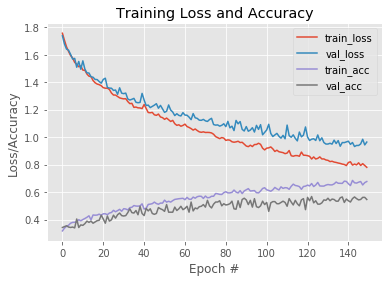

In [48]:
# plot the training loss and accuracy for each epoch
N = np.arange(0,EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
#plt.savefig("training_performance_250_architecture_04.png")
plt.show()

In [31]:
print(H.history.keys())
#print(H.history["accuracy"])

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


# Save the weights


In [32]:
classifier.save("keras_architecture_01_with_encoder.model")